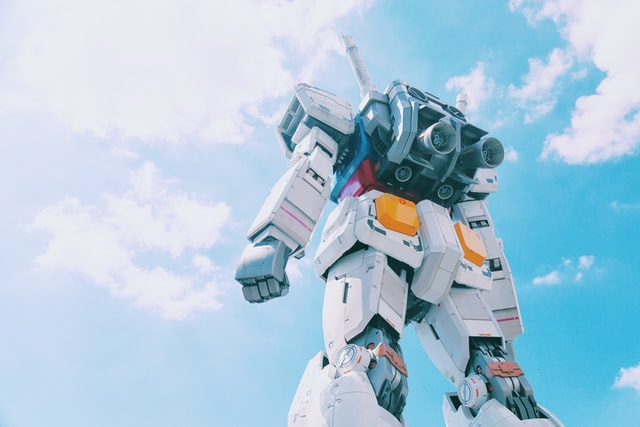

<center>Photo by Bruce Tang on Unsplash</center>


# Table of Contents
1. [Recommender systems](#Recommender-Systems)
2. [Anime ratings](#Anime-ratings)
3. [Collaborative filtering](#Collaborative-filtering)
    1. [Neighborhood-based methods](#Neighborhood-based-methods)
        1. [User-based Basic KNN](#User-based-Basic-KNN)
        2. [User-based KNN with means](#User-based-KNN-with-means)
    2. [Model-based methods](#Model-based-methods)
4. [Content-based filtering](#Content-based-filtering)
4. [Resources](#Resources)


<a id="Recommender-Systems"></a>
# Recommender systems

On large databases, users may not know what to search for or they miss items that they could have liked. Recommender systems aim to help users find items that they may like in a large database. 

According to Google:

> - 40% of app installs on Google Play come from recommendations.
- 60% of watch time on YouTube comes from recommendations.

Source: [Google developer's recommendation systems course](https://developers.google.com/machine-learning/recommendation/overview)

In this notebook we'll see the basics of recommender systems applied to the recommendation of animes using the Surprise library.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from surprise import Dataset, Reader, NormalPredictor, KNNBasic, KNNWithMeans, SVD, accuracy
from surprise.model_selection import cross_validate

from sklearn.neighbors import NearestNeighbors

plt.style.use('seaborn-colorblind')
np.random.seed(8)
warnings.filterwarnings(action="ignore")

<a id="Anime-ratings"></a>
# Anime ratings

The file `ratings.csv` contains a line for each explicit rating that a user has given to an anime. For example:

In [ ]:
df_ratings = pd.read_csv("/kaggle/input/anime-recommendations-database/rating.csv")

display(df_ratings.sample(5, random_state=8))

print(f"""Number of total ratings: {df_ratings.shape[0]}. 
Number of different users: {df_ratings.user_id.nunique()}. 
Number of different animes: {df_ratings.anime_id.nunique()}.""")

The ratings go from 1 to 10. Where 1 means that the user didn't like the anime at all. And 10 means that the user liked it very much. 

There is a special -1 rating that represents users that have watched an anime but didn't rate it. If we had more information like watch time we could infer an explicit rating. But we don't, so for simplicity we'll treat these ratings as missing ratings by removing them.

In [ ]:
def countplot_with_percentages(serie):
    ax = sns.countplot(serie)
    total_count = serie.count()

    for p in ax.patches:
        x = p.get_bbox().get_points()[:, 0]
        y = p.get_bbox().get_points()[1, 1]
        percentage = p.get_height() / total_count * 100
        ax.annotate(f'\n{percentage: .2f}%',
                    (x.mean(), y), ha='center', size=14)


plt.figure(figsize=(12, 6))
plt.axes(yscale="log")

countplot_with_percentages(df_ratings.rating)

plt.title("Distribution of Ratings in log scale")
plt.ylabel("Count in log scale")
plt.xlabel("Ratings");

Moreover, I'll just take the first 50,000 ratings from the data to keep a reasonable time and memory cost for running this notebook. Tough the results will be bad, the purpose of this notebook is educational, for a large scale system we can look at implementations of recommender system methods that can deal with a huge ammount of data. For instance, there are some [implementations for Apache Spark](https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html).

In [ ]:
cleaned_df_ratings = df_ratings[df_ratings.rating > 0].iloc[:50000, :]
reader = Reader(line_format='user item rating')
data = Dataset.load_from_df(cleaned_df_ratings, reader)

In [ ]:
plt.figure(figsize=(12, 6))
#plt.axes(yscale="log")

countplot_with_percentages(cleaned_df_ratings.rating)

plt.title("Distribution of Ratings after cleaning the data")
plt.ylabel("Count")
plt.xlabel("Ratings");

<a id="Collaborative-filtering"></a>
# Collaborative filtering

The format of the data can be seen as a sparse representation of a matrix of ratings. Its dimensions are $m \times n$, where $m$ is the number of users and $n$ is the number of animes and each cell of the matrix represents the rating that an user gives to an anime.

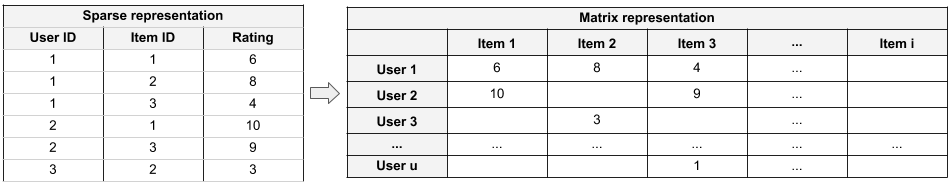

The basic idea of collaborative filtering algorithms is that we can look for similar users and/or similar items (animes in this case) to decide what to recommend a certain user. For example, **if Alice and Bob like similar items they will have similar ratings on those items, so we can recommend to Alice something that Bob likes and that she hasn't seen yet**.

Two major types of collaborative filtering algorithms are neighborhood-based methods and model-based methods.

<a id="Neighborhood-based-methods"></a>
## Neighborhood-based methods

These were among the first methods developed for recommender systems. To know what to recommend, these methods calculate a similarity function (for instance, cosine similarity or Pearson correlation) between all users or items. Then, a prediction of the rating that the user would give to a certain item is calculated based on the k most similar items. Finally, these predictions are used to know what would be best to recommend to the user.

<a id="User-based-Basic-KNN"></a>
### User-based Basic KNN

Lets see how a very simple neighborhood-based algorithm works on our data. This algorithm first calculates the pearson similarity between all pair of users. Then, to predict a rating for an item, we take the ratings that the 40 most similar users gave to the item. Finally, the average of the ratings weighted by the similarities is returned:

$$
\hat{r}_{ui} = \frac{ \sum\limits_{v \in N_i(u)} \text{pearson_sim}(u, v) \cdot r_{vi}} {\sum\limits_{v \in N_i(u)} \text{pearson_sim}(u, v)}
$$

Note: $\hat{r}_{ui}$ is the prediction of the rating that user $u$ would give to the item $i$. And $N_i(u)$ is the neigborhood of the 40 most similar users to $u$ that have rated the item $i$.

Below we can see the results after 5-folds cross-validation using the [Surprise library](https://surprise.readthedocs.io/en/stable/index.html)

In [ ]:
algorithm = KNNBasic(k=40, random_state=8, sim_options={
    'name': 'pearson',
    'user_based': True
})

cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=True);

We have around 3 units of Root Mean Squared Error in each fold. These results are bad taking into account that the ratings vary from 1 to 10 and that most of the ratings are around 7 to 10. However this is expected as we are using about 0.6% of the data to keep the computation time and memory reasonable.

<a id="User-based-KNN-with-means"></a>
### User-based KNN with means

Not every user rate items the same way, some tend to give generous ratings, whereas others tend to rate all items negatively. Yet they may be correlated so there is the posibility that, when trying to predict the rating that a "generous" user would give to an item, many of the similar users tend to give lower ratings. So the predicted rating will not be as high as the ones that the user tends to give.

A modification of the basic KNN method is to mean-center the ratings to account for this difference of scales between different users:

$$
\hat{r}_{ui} = \mu_u + \frac{ \sum\limits_{v \in N_i(u)} \text{pearson_sim}(u, v) \cdot (r_{vi} - \mu_v)} {\sum\limits_{v \in N_i(u)} \text{pearson_sim}(u, v)}
$$

In [ ]:
algorithm = KNNWithMeans(k=40, random_state=8, sim_options={
    'name': 'pearson',
    'user_based': True
})

cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=True);

There doesn't seem to be a significant improvement. Again, this could be due to the reduced dataset that we are using. And/or maybe because most of the users tend to give "generous" ratings.

<a id="Model-based-methods"></a>
## Model-based methods

Neighborhood-based methods are very simple but they have several disadvantages. Two fundamental problems are the following:

- They need to use the matrix of ratings to predict a new rating. Hence, they are not scalable to large datasets. 
- When the dataset gets very sparse, these methods get less accurate: as a dataset gets more sparse, it gets more likely that two users or items don't have many overlapping values, which makes the similarity measures unreliable or not computable if no overlapping value is found.

Model-based methods build a model from the matrix of ratings. This implies a important decrease of the memory needed. And one of the most popular methods also deals well with the sparsity of the data: SVD (Singular Value Decomposition). SVD is a well-known method for matrix factorization that can describe any matrix as the product of three matrices.

<!-- from https://tex.stackexchange.com/questions/183090/replicate-the-singular-value-decomposition-figure-in-latex -->
$$
\begin{equation}
\underbrace{\mathbf{R}}_{m \times n} = \underbrace{\mathbf{U}}_{m \times m} \cdot \underbrace{\mathbf{\Sigma}}_{n\times n} \cdot \underbrace{\mathbf{V}^{\text{T}}}_{n \times n}
\end{equation}
$$

The key component for using this method in the context of recommendation systems is the $\Sigma$ matrix. It is a diagonal matrix whose entries are ordered from higher to lower values. Thanks to this, **we can keep only the first few entries and still have a very good approximation of $\mathbf{R}$** with a much lower memory cost. 

So we can represent the matrix of ratings as the product of two matrices that are much smaller:

$$
\begin{equation}
\underbrace{\mathbf{R}}_{m \times n} \approx (\underbrace{\mathbf{U}}_{m \times r} \cdot \underbrace{\sqrt{\mathbf{\Sigma}}}_{r\times r}) \cdot (\underbrace{\sqrt{\mathbf{\Sigma}}}_{r\times r} \cdot \underbrace{\mathbf{V}^{\text{T}}}_{r \times n})
\end{equation}
$$

$r$ has to be specified by the user and it can be much smaller than $n$. This representation of the data in a low-dimensional space is known in Machine Learning as an embedding. And a very interesting property of embeddings is that, to do such a good job representing the original data in a lower dimensional space, they have to capture some of the semantics of the original data. Though we cannot know for sure what that could be. 

In the book "Recommender Systems The Textbook" by Charu C. Aggarwal, the author gives an illustrative example showing how powerful these embeddings can be. Though we cannot interpret the embeddings, we know that they have to capture some semantics of the original data, so they could be capturing, for example, the genre of the items and the preference of the users for each genre.

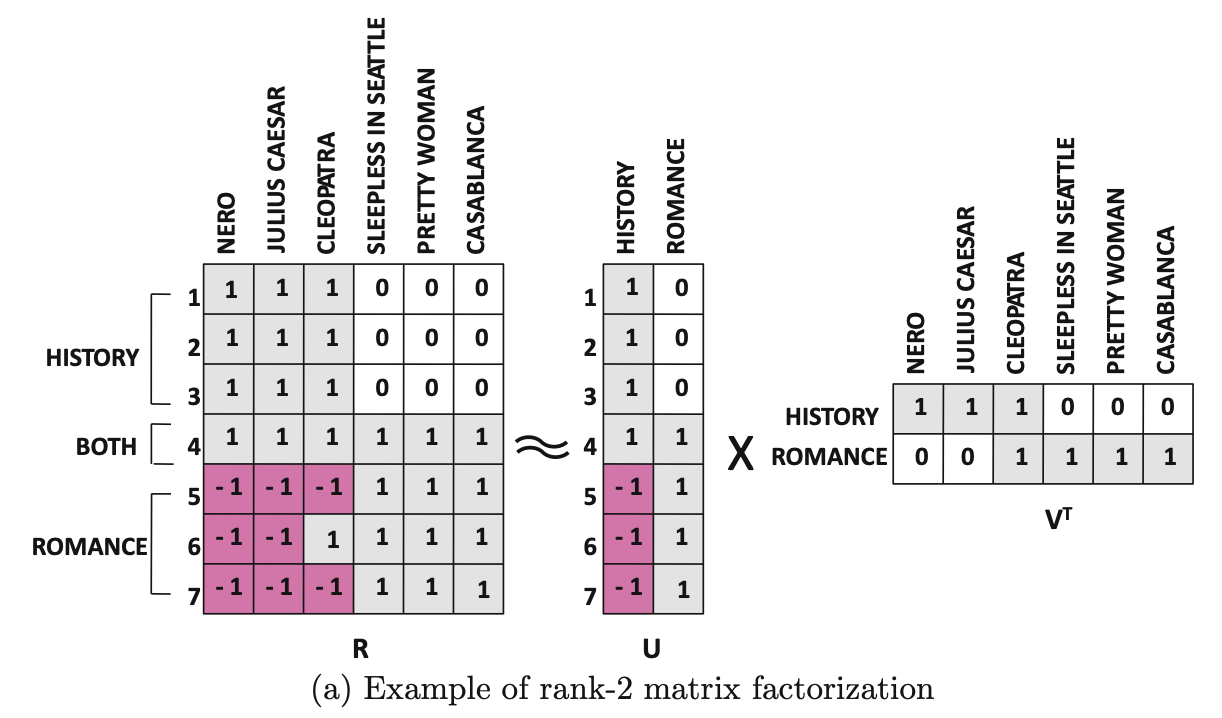

There are many ways to compute singular value decompositions, the one that we are using next is the one that Simon Funk used during the Netflix Price competition, where his team got third place. He explains it in detail in [a blog post](https://sifter.org/~simon/journal/20061211.html). But the the gist of it, in his own words:

> But, just because there are five hundred really complicated ways of computing singular value decompositions in the literature doesn't mean there isn't a really simple way too: Just take the derivative of the approximation error and follow it. This has the added bonus that we can choose to simply ignore the unknown error on the 8.4B empty slots.

In [ ]:
algorithm = SVD(random_state=8, n_factors=100)

cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=True);

Again, we don't see a significant improvement due to the bad subset selection of the data.

<a id="Content-based-filtering"></a>
# Content-based Filtering

So far we've only looked at Collaborative filtering approaches. They can be very powerful but they only focus on the interactions between users and/or items. We may have more information about the items that isn't exploited with collaborative filtering methods.

Content-based filtering uses item features to recommend similar items. It is usually seen applied to text because we can extract a lot of information from them with Natural Language Processing methods. But we can also use content-based filtering in this context because we have access to some information about the animes.

In [ ]:
df_animes = pd.read_csv("/kaggle/input/anime-recommendations-database/anime.csv", index_col="anime_id")
df_animes.head()

In particular we'll use the genre and type of anime as features to use as input to a k-nearest neighbor algorithm.

First, for simplicity, lets drop the few animes that have missing values and represent the genres in a simple one-hot encoding way.

In [ ]:
# Drop the animes with null values
df_clean_animes = df_animes[df_animes.genre.notna() & df_animes.type.notna()]

# First, split the genre column by comma and expand the list so there is
# a column for each genre. Now we have 13 columns, because the anime with
# most genres tags has 13 tags
genres = df_clean_animes.genre.str.split(", ", expand=True)

# Now we can get the list of unique genres. We "convert" the dataframe into
# a single dimension array and take the unique values
unique_genres = pd.Series(genres.values.ravel('K')).dropna().unique()

# Getting the dummy variables will result in having a lot more columns
# than unique genres
dummies = pd.get_dummies(genres)

# So we sum up the columns with the same genre to have a single column for
# each genre
for genre in unique_genres:
    df_clean_animes["Genre: " + genre] = dummies.loc[:, dummies.columns.str.endswith(genre)].sum(axis=1)
    
# Add the type dummies
type_dummies = pd.get_dummies(df_clean_animes.type, prefix="Type:", prefix_sep=" ")
df_clean_animes = pd.concat([df_clean_animes, type_dummies], axis=1)

df_clean_animes = df_clean_animes.drop(columns=["name", "type", "genre", "episodes", "rating", "members"])
df_clean_animes.head()

Now we are ready to build and use a k-nearest neighbors model. Lets see what are the 15 most similar animes to "Dragon Ball Z" that the model returns

In [ ]:
# Helper function to get the features of an anime given its name
def get_features_from_anime_name(name):
    return df_clean_animes.loc[df_animes[df_animes.name == name].index]


# Build and "train" the model
neigh = NearestNeighbors(15)
neigh.fit(df_clean_animes.values)

# Get the features of this anime
item_to_compare = get_features_from_anime_name("Dragon Ball Z")

# Get the indices of the most similar items found
# Note: these are ignoring the dataframe indices and starting from 0
index = neigh.kneighbors(item_to_compare, return_distance=False)

# Show the details of the items found
df_animes.loc[df_animes.index[index][0]]

Looks like many of the Dragon Ball series and movies have the same genre tags as "Dragon Ball Z" so the nearest neighbors did a good returning those.

<a id="Resources"></a>
## Resources

- [Google recommendation systems course](https://developers.google.com/machine-learning/recommendation)
- [Book "Recommender Systems The Textbook" by Charu C. Aggarwal](https://link.springer.com/book/10.1007/978-3-319-29659-3). A great book that is available for free at the time of writting this notebook. 
- [Simon Funk's blog post](https://sifter.org/~simon/journal/20061211.html). A post explaining his version of the SVD algorithm that got him third place on the Netflix price competition.
- [Paper "Deep Neural Networks for YouTube Recommendations" by Paul Covington, Jay Adams & Emre Sargin](https://research.google/pubs/pub45530/). A paper explaining a high level overview of the YouTube recommendation system
- [Surprise library](https://github.com/NicolasHug/Surprise)